In [1]:
from fastai.vision import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

In [3]:
path_img = path / 'images'
path_lbl = path / 'labels'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f01020.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06390.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01830.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f02340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01230_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009150_P.png')]

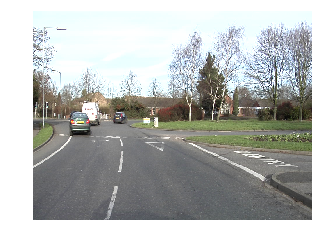

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

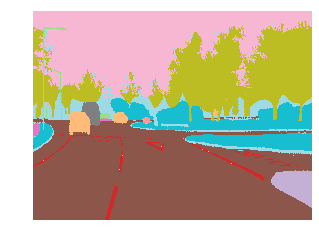

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
size = src_size//2

In [12]:
free = gpu_mem_get_free_no_cache()
if free > 8200: bs = 8
else: bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [13]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs).normalize(imagenet_stats))

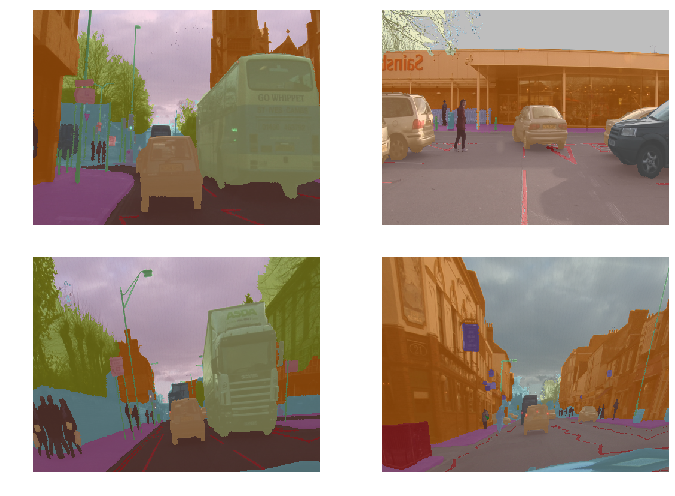

In [15]:
data.show_batch(2, figsize=(10, 7))

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()        

In [17]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


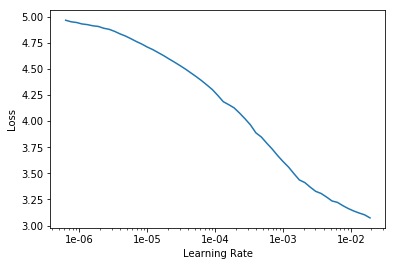

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr = 3e-4

In [20]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.449477,1.653403,0.598325,00:56
1,1.410975,0.918607,0.755574,00:52
2,0.968805,0.698455,0.826381,00:52
3,0.752159,0.591607,0.845402,00:52
4,0.669874,0.526228,0.854444,00:52
5,0.583990,0.460237,0.861300,00:53
6,0.541394,0.460437,0.871923,00:52
7,0.511106,0.411040,0.881330,00:53
8,0.476913,0.436143,0.871838,00:53
9,0.410378,0.338858,0.899255,00:53


In [21]:
learn.save('stage-1')

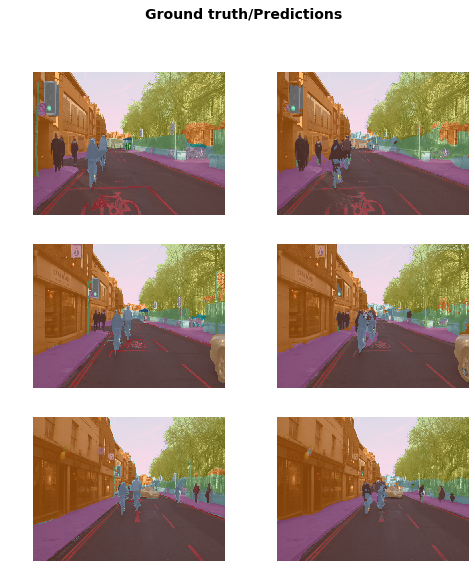

In [22]:
learn.show_results(rows=3, figsize=(8,9))

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


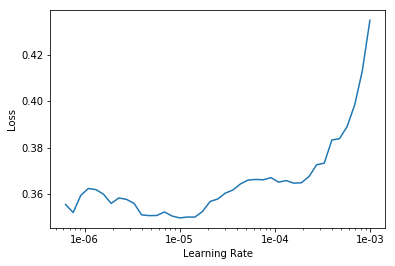

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(12, slice(3e-5, lr/5), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.362728,0.332090,0.901490,00:54
1,0.359312,0.331325,0.901424,00:54
2,0.353746,0.324897,0.903452,00:54
3,0.346880,0.332332,0.898921,00:54
4,0.338877,0.318190,0.904844,00:54
5,0.331056,0.332489,0.901870,00:54
6,0.323903,0.322571,0.903388,00:54
7,0.313111,0.327887,0.900406,00:54
8,0.307449,0.319792,0.902677,00:54
9,0.301189,0.356713,0.897742,00:54


In [26]:
learn.save('stage-2');

In [27]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [28]:
size = src_size

In [29]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 15643MB of GPU RAM free


In [30]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [31]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)

In [ ]:
learn.load('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


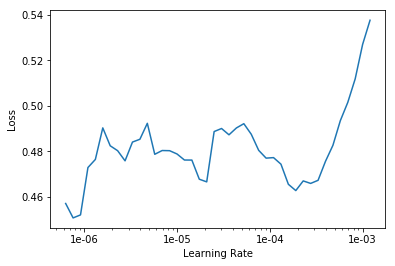

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
lr = 4e-4

In [35]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.370003,0.338027,0.906282,03:53
1,0.365358,0.387194,0.890439,03:50
2,0.362653,0.349310,0.898990,03:50
3,0.390263,0.355750,0.898965,03:50
4,0.399498,0.345324,0.907122,03:50
5,0.408340,0.328285,0.909529,03:50
6,0.404928,0.343951,0.904894,03:50
7,0.374265,0.342030,0.912747,03:50
8,0.321558,0.280801,0.920189,03:50
9,0.248418,0.257238,0.927194,03:51


In [36]:
learn.save('stage-1-big')

In [37]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


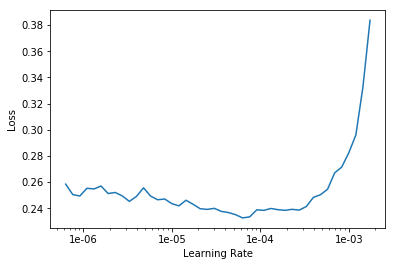

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(10, slice(3e-5, lr/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.233156,0.253872,0.928320,03:57
1,0.233162,0.259009,0.928239,03:57
2,0.247114,0.262911,0.923510,03:57
3,0.232005,0.248579,0.928698,03:56
4,0.212730,0.266726,0.925897,03:57
5,0.204894,0.239148,0.931794,03:57
6,0.201748,0.228696,0.936874,03:57
7,0.187256,0.233928,0.934955,03:57
8,0.182969,0.234394,0.936563,03:57
9,0.184228,0.238375,0.935510,03:57


In [40]:
learn.save('stage-2-big')

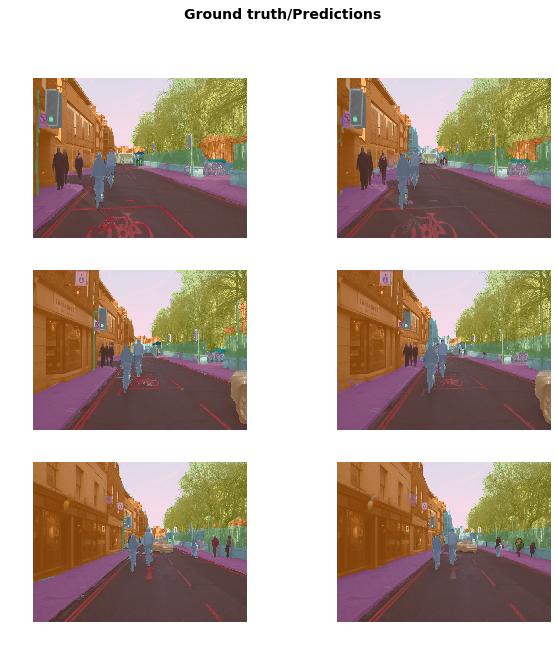

In [41]:
learn.show_results(rows=3, figsize=(10,10))